In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda
import time
import math

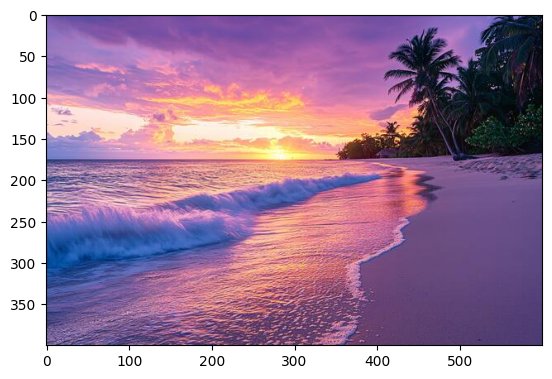

In [2]:
img = plt.imread('./image.jpg')
plt.imshow(img)
plt.show()

In [3]:
height = img.shape[0]
width = img.shape[1]
depth = img.shape[2]

In [4]:
@cuda.jit
def gpu_color2rgb_2d(img_array, gray_img_ary):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    if i < gray_img_ary.shape[0] and j < gray_img_ary.shape[1]:
        gray_img_ary[i][j] = (1/3) * (img_array[i][j][0] + img_array[i][j][1] + img_array[i][j][2])

Elapsed GPU time = 0.2535581588745117s


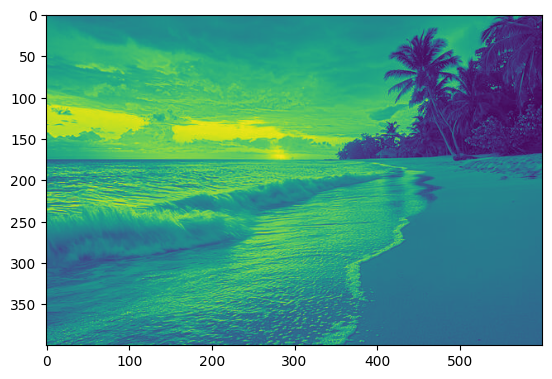

In [5]:
img_array = cuda.to_device(img)
gray_img_ary = cuda.device_array(shape=(height, width))

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(height / threadsperblock[0])
blockspergrid_y = math.ceil(width / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
start = time.time()
gpu_color2rgb_2d[blockspergrid, threadsperblock](img_array, gray_img_ary)
end = time.time()
print("Elapsed GPU time = {}s".format((end - start)))
gray_img = gray_img_ary.copy_to_host()
plt.imshow(gray_img)
plt.show()


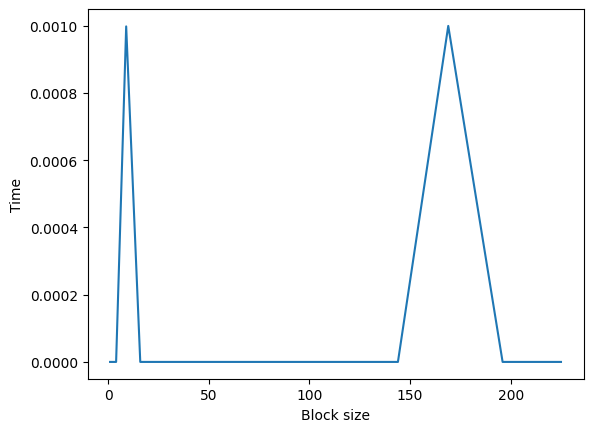

In [6]:
def different_block_size(threadsperblock_value_list):
    values = []
    for threadsperblock in threadsperblock_value_list:
        blockspergrid_x = math.ceil(height / threadsperblock[0])
        blockspergrid_y = math.ceil(width / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        # print(blockspergrid)

        start = time.time()
        gpu_color2rgb_2d[blockspergrid, threadsperblock](img_array, gray_img_ary)
        end = time.time()
        duration = end - start
        values.append((threadsperblock[0]*threadsperblock[1], duration))
    return values

threadsperblock_values_init = np.arange(1, 16, 1)
threadsperblock_value_list = []
for v in threadsperblock_values_init:
    threadsperblock_value_list.append((v, v))
values = different_block_size(threadsperblock_value_list)
threadsperblock_val = [value[0] for value in values]
time_val = [value[1] for value in values]
plt.plot(threadsperblock_val, time_val)
plt.xlabel("Block size")
plt.ylabel("Time")
plt.show()